In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [84]:
torch.manual_seed(0)

class LinearNeuralTangentKernel(torch.nn.Linear): 
    def __init__(self, in_features, out_features, bias=True, beta=1, w_sig=1):
        self.beta = beta
        super(LinearNeuralTangentKernel, self).__init__(in_features, out_features)
        self.reset_parameters()
        self.w_sig = w_sig / np.sqrt(self.out_features)
      
    def reset_parameters(self):
        # torch.nn.init.xavier_normal_(self.weight)
        torch.nn.init.normal_(self.weight, mean=0, std=1)
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0, std=1)

    def forward(self, input):
        return F.linear(input, self.w_sig * self.weight, self.beta * self.bias) 

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, beta={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.beta
        )

class PINN(torch.nn.Module):
    def __init__(self, layers_width):
        super(PINN, self).__init__()
        # Initialize network weights and biases
        self.layers_width = layers_width
        self.initialize_NN()

    # Evaluates the forward pass
    def forward(self, H):
        num_layers = len(self.layers_width)
        for l in range(0, num_layers - 2):
            H = torch.tanh(self.layers[l](H))
        H = self.layers[-1](H)
        return H

     # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self):
        num_layers = len(self.layers_width)
        self.layers = torch.nn.ModuleList()
        for l in range(0, num_layers - 1):
            self.layers.append(LinearNeuralTangentKernel(self.layers_width[l], self.layers_width[l+1]))
        

class PINN_SOLVER:
    def __init__(self, X_u, Y_u, X_r, Y_r, params):

        # self.mu_X, self.sigma_X = X_r.mean(0), X_r.std(0)
        # self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.N_u = X_u.shape[0]
        self.N_r = X_r.shape[0]

        # Normalize (may be better to normalize before feed the data into model), if needed
        # X_u_normalized = (X_u - self.mu_X) / self.sigma_X
        # X_r_normalized = (X_r - self.mu_X) / self.sigma_X
        self.X_u = X_u
        self.X_r = X_r
        self.Y_u = Y_u
        self.Y_r = Y_r
        self.X_u.requires_grad=True
        self.X_r.requires_grad=True

        # Initialize network 
        layers_width = params['layers_width']
        self.model = PINN(layers_width)
        
        # Logger
        # Loss logger
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

        # NTK logger 
        self.K_uu_log = []
        self.K_rr_log = []
        self.K_ur_log = []
        
        # Weights logger 
        self.weights_log = []
        self.biases_log = []

        self.loss_fnc = torch.nn.MSELoss()

        self.lambda_b = 1
        self.lambda_r = 1
        
        # training parameters
        epochs = params['epochs']
        starter_lr = params['lr']
        # gamma = params['gamma']
        # milestones = params['milestones']
        # momentum = params['momentum']
        # lr_lambda = params['lr_lambda']
        
        # Define optimizer with learning rate schedule
        self.optimizer = optim.SGD(self.model.parameters(),
                              lr=starter_lr)
        # self.optimizer = optim.Adam(self.model.parameters(),lr=0.005)
        # scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=milestones, gamma=gamma)
        # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    # Trains the model by minimizing the MSE loss
    def fit(self, log_NTK=False, log_weights=False, weighted_loss=False):
        self.model.train()

        start_time = timeit.default_timer()
        for iter in range(epochs):
            self.optimizer.zero_grad()

            # forward pass
            self.u_bc_pred = self.model(self.X_u)
            loss_bcs = self.loss_fnc(self.u_bc_pred, self.Y_u)
            self.loss_bcs_log.append(loss_bcs.data)

            # u_r_pred = self.model(X_r)
            # u_x = torch.autograd.grad(u_r_pred, X_r, torch.ones_like(u_r_pred), retain_graph=True, create_graph=True)[0] #/ self.sigma_X
            # self.u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0] #/ self.sigma_X
            self.u_xx = self.compute_uxx(self.X_r)
            loss_res = self.loss_fnc(self.u_xx, self.Y_r)
            self.loss_res_log.append(loss_res.data)
            
            # Total loss
            loss = self.lambda_r*loss_res + self.lambda_b*loss_bcs    # need to tune the weights on each loss term
            self.loss_log.append(loss.data)

            # Print
            if iter % 500 == 0:
                elapsed = timeit.default_timer() - start_time
                print('Epoch: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e ,Time: %.2f' %
                      (iter, loss, loss_bcs, loss_res, elapsed))
                
                start_time = timeit.default_timer()

                if log_NTK:
                    # provide x, x' for NTK
                    # print("Compute NTK...")
                    Kuu, Krr, Kur = self.compute_ntk()
                    self.K_uu_log.append(Kuu)
                    self.K_ur_log.append(Kur)
                    self.K_rr_log.append(Krr)

                    if weighted_loss:
                        K_trace = torch.trace(Kuu) + torch.trace(Krr)
                        self.lambda_b = K_trace/torch.trace(Kuu)
                        self.lambda_r = K_trace/torch.trace(Krr)
                      
                # if log_weights:
                #     print("Weights stored...")
                #     weights = self.sess.run(self.weights)
                #     biases = self.sess.run(self.biases)
                    
                #     self.weights_log.append(weights)
                #     self.biases_log.append(biases)

            # backpropagation
            loss.backward()
            self.optimizer.step()
                
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        self.model.eval()
        with torch.no_grad():
          # X_star = (X_star - self.mu_X) / self.sigma_X
          u_star = self.model(X_star)
        return u_star

    def compute_uxx(self, X_r):
        u_r_pred = self.model(X_r)
        u_x = torch.autograd.grad(u_r_pred, X_r, torch.ones_like(u_r_pred), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        # u_xx.requires_grad = True
        return u_xx

    def compute_jacobian(self):
        Ju = []
        Jr = []
        for i in range(self.N_u):
            Ju.append(list_to_vector(torch.autograd.grad(self.u_bc_pred[i], self.model.parameters(), torch.ones_like(self.u_bc_pred[i]), retain_graph=True)))
        for i in range(self.N_r):
            Jri = torch.autograd.grad(self.u_xx[i], self.model.parameters(), torch.ones_like(self.u_xx[i]), allow_unused=True, retain_graph=True)
            Jri_list = []
            for j, param in enumerate(self.model.parameters()):
                if Jri[j] is not None:
                    Jri_list.append(Jri[j])
                else:
                    Jri_list.append(torch.zeros_like(param))
            Jr.append(list_to_vector(Jri_list))
        Ju = torch.vstack(Ju)
        Jr = torch.vstack(Jr)
        return Ju, Jr

    def compute_ntk(self):
        Ju, Jr = self.compute_jacobian()
        Kuu = Ju @ Ju.T
        Krr = Jr @ Jr.T
        Kur = Ju @ Jr.T
        # K1 = torch.hstack((Kuu, Kur))
        # K2 = torch.hstack((Kur.T, Krr))
        # K = torch.vstack((K1,K2))
        return Kuu, Krr, Kur


def list_to_vector(list_):
    return torch.cat([x.reshape(-1) for x in list_])

# def vector_to_list(vector):
#     list_ = []
#     counter = 0
#     for param in list(self.parameters()):
#         list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
#         counter += torch.numel(param)
#     return list_

In [74]:
# Define solution and its Laplace
a = 0.5

def u(x, a):
  return np.sin(np.pi * a * x)

def u_xx(x, a):
  return -(np.pi * a)**2 * np.sin(np.pi * a * x)

# Define computional domain
bc1_coords = np.array([[0.0],
                       [0.0]])

bc2_coords = np.array([[1.0],
                       [1.0]])

dom_coords = np.array([[0.0],
                       [1.0]])

# Training data on u(x) -- Dirichlet boundary conditions

n  = 100

X_bc1 = dom_coords[0, 0] * np.ones((n // 2, 1))
X_bc2 = dom_coords[1, 0] * np.ones((n // 2, 1))
X_u = np.vstack([X_bc1, X_bc2])
Y_u = u(X_u, a)

X_r = np.linspace(dom_coords[0, 0], dom_coords[1, 0], n)[:, None]
Y_r = u_xx(X_r, a)

# convert to torch tensor
X_u = torch.tensor(X_u).float()
Y_u = torch.tensor(Y_u).float()
X_r = torch.tensor(X_r).float()
Y_r = torch.tensor(Y_r).float()

# Test width = 512

In [78]:
# Define model
layers_width = [1, 512, 1]  
# layers_width = [1, 512, 512, 512, 1]
epochs = 40001
lr = 1e-5
# gamma = 0.8
# lr_lambda = lambda it: lr * gamma**(it/1000)

train_params = {
    'layers_width':     layers_width,
    'epochs':           epochs,
    'lr':               lr,
    # 'momentum':         0.9,
    # 'milestones':       [ms for ms in range(1,epochs) if ms%10000==0],
    # 'milestones':         [20000, 40000, 60000],
    # 'gamma':            gamma,
    # 'lr_lambda':        lr_lambda,
}

solver = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)  


In [79]:
for param in solver.model.parameters():
  print(param.shape)

torch.Size([512, 1])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])


In [80]:
# Train model
solver.fit(log_NTK=True,weighted_loss=True)

Epoch: 0, Loss: 3.757e+00, Loss_bcs: 1.011e+00, Loss_res: 2.746e+00 ,Time: 0.00
tensor(1.0000)
tensor(45614.9492)
Epoch: 500, Loss: 7.098e+03, Loss_bcs: 1.456e+01, Loss_res: 1.553e-01 ,Time: 0.98
tensor(1.0075)
tensor(133.9030)
Epoch: 1000, Loss: 2.553e+01, Loss_bcs: 7.880e+00, Loss_res: 1.314e-01 ,Time: 0.94
tensor(1.0074)
tensor(136.2680)
Epoch: 1500, Loss: 2.516e+01, Loss_bcs: 7.855e+00, Loss_res: 1.265e-01 ,Time: 1.00
tensor(1.0077)
tensor(131.0833)
Epoch: 2000, Loss: 2.400e+01, Loss_bcs: 7.827e+00, Loss_res: 1.229e-01 ,Time: 0.96
tensor(1.0079)
tensor(127.3613)
Epoch: 2500, Loss: 2.313e+01, Loss_bcs: 7.799e+00, Loss_res: 1.199e-01 ,Time: 0.93
tensor(1.0081)
tensor(124.4200)
Epoch: 3000, Loss: 2.242e+01, Loss_bcs: 7.771e+00, Loss_res: 1.172e-01 ,Time: 0.98
tensor(1.0083)
tensor(121.9493)
Epoch: 3500, Loss: 2.180e+01, Loss_bcs: 7.743e+00, Loss_res: 1.147e-01 ,Time: 0.94
tensor(1.0084)
tensor(119.7775)
Epoch: 4000, Loss: 2.124e+01, Loss_bcs: 7.716e+00, Loss_res: 1.124e-01 ,Time: 0.92

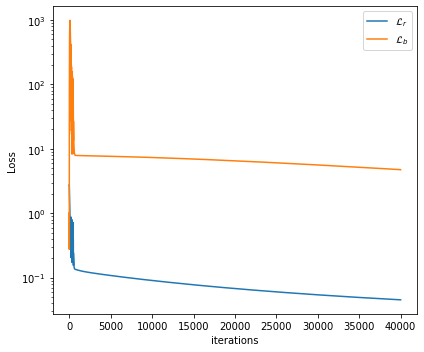

In [81]:
loss_bcs = solver.loss_bcs_log
loss_res = solver.loss_res_log

fig = plt.figure(figsize=(6,5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{b}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Model prediction

In [82]:
nn = 1000
X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
u_star = u(X_star, a)
r_star = u_xx(X_star, a)

# convert to tensor
X_star = torch.tensor(X_star).float()
u_star = torch.tensor(u_star).float()
r_star = torch.tensor(r_star).float()

# Predictions
u_pred = solver.predict_u(X_star)
# r_pred = model.predict_r(X_star)
error_u = torch.norm(u_star - u_pred, 2) / torch.norm(u_star, 2)
# error_r = torch.norm(r_star - r_pred, 2) / torch.norm(r_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
# print('Relative L2 error_r: {:.2e}'.format(error_r))

Relative L2 error_u: 1.78e+00


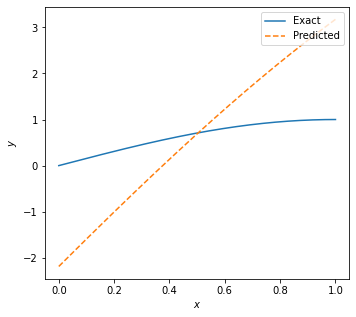

In [83]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(X_star, u_star, label='Exact')
plt.plot(X_star, u_pred.detach().numpy(), '--', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper right')

## NTK values

In [22]:
# Create empty lists for storing the eigenvalues of NTK
lambda_K_log = []
lambda_K_uu_log = []
lambda_K_ur_log = []
lambda_K_rr_log = []

# Restore the NTK
K_uu_list = solver.K_uu_log
K_ur_list = solver.K_ur_log
K_rr_list = solver.K_rr_log
K_list = []
    
for k in range(len(K_uu_list)):
    K_uu = K_uu_list[k]
    K_ur = K_ur_list[k]
    K_rr = K_rr_list[k]
    
    K = np.concatenate([np.concatenate([K_uu, K_ur], axis = 1),
                        np.concatenate([K_ur.T, K_rr], axis = 1)], axis = 0)
    K_list.append(K)

    # Compute eigenvalues
    lambda_K, _ = np.linalg.eig(K)
    lambda_K_uu, _ = np.linalg.eig(K_uu)
    lambda_K_rr, _ = np.linalg.eig(K_rr)
    
    # Sort in descresing order
    lambda_K = np.sort(np.real(lambda_K))[::-1]
    lambda_K_uu = np.sort(np.real(lambda_K_uu))[::-1]
    lambda_K_rr = np.sort(np.real(lambda_K_rr))[::-1]
    
    # Store eigenvalues
    lambda_K_log.append(lambda_K)
    lambda_K_uu_log.append(lambda_K_uu)
    lambda_K_rr_log.append(lambda_K_rr)

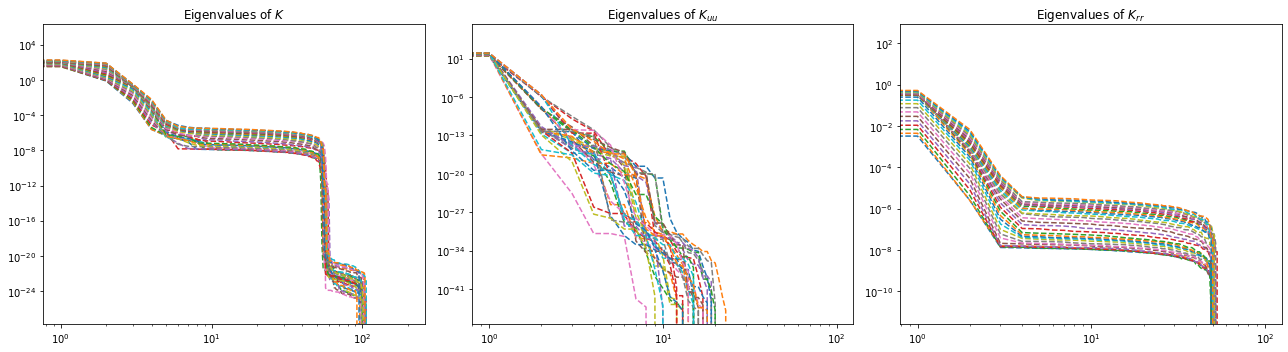

In [23]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
for i in range(1, len(lambda_K_log), 10):
    plt.plot(lambda_K_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}$')
plt.tight_layout()

plt.subplot(1,3,2)
for i in range(1, len(lambda_K_uu_log), 10):
    plt.plot(lambda_K_uu_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{uu}$')
plt.tight_layout()

plt.subplot(1,3,3)
for i in range(1, len(lambda_K_log), 10):
    plt.plot(lambda_K_rr_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{rr}$')
plt.tight_layout()
plt.show()

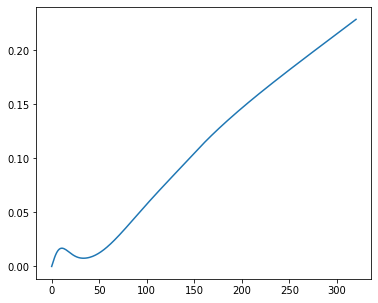

In [24]:
# Change of the NTK
NTK_change_list = []
K0 = K_list[0]
for K in K_list:
    diff = np.linalg.norm(K - K0) / np.linalg.norm(K0) 
    NTK_change_list.append(diff)

fig = plt.figure(figsize=(6,5))
plt.plot(NTK_change_list)